<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


    
# 40_HierarchicalLinearRegression

#### Demonstrate pooling and hierarchical linear regression


Create a set of progressively more complex models, trying to show the effect of manufacturer upon NOx emissions. I'll evaluate the models using WAIC and PPC.

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    + [Prepare Dataset](#Prepare-Dataset)
    + [Describe Dataset](#Describe-Dataset)


+ [Choose Features](#Choose-Features)
    + [Create Modelspecs and Design Matrices](#Create-Modelspecs-and-Design-Matrices)


+ [Pooled Model](#Pooled-Model)


+ [Unpooled Model](#Unpooled-Model)
    + [Evaluate Manufacturers using Unpooled Model](#Evaluate-Manufacturers-using-Unpooled-Model)
    
    
+ [Digression: Fully Unpooled Model](#Digression:-Fully-Unpooled-Model)


+ [Partially-Pooled Model](#Partially-Pooled-Model)
    + [Evaluate Manufacturers using Partially-Pooled Model](Evaluate-Manufacturers-using-Partially-Pooled-Model)
    + [Can we comment on Volkswagen's NOx emissions at `mfr` level?](#Can-we-comment-on-Volkswagen's-NOx-emissions at `mfr` level?)


+ [Hierarchical Model of Parent and Manufacturer](#Hierarchical-Model-of-Parent-and-Manufacturer)



+ [Summary Insights and Notes](#Summary-Insights-and-Notes)
    + [Model Comparison using WAIC](#Model-Comparison-using-WAIC)
    + [Comparing Car Manufacturers and Parent Companies](Comparing-car-manufacturers-and-parent-companies)




+ [Digression: Model Comparison using WAIC](#Digression:-Model-Comparison-using-WAIC)


+ [Final look at parent with a Partially-Pooled Model](#Final-look-at-parent-with-a-Partially-Pooled-Model)
    + [Evaluate Manufacturers using Partially-Pooled `parent` Model](Evaluate-Manufacturers-using-Partially-Pooled-`parent`-Model)
    + [Can we comment on Volkswagen's NOx emissions at `parent` level?](#Can-we-comment-on-Volkswagen's-NOx-emissions at `parent` level?)



# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux
# %connect_info

In [2]:
# general packages
import sys
import sqlite3
from convenience_functions import *
from ipywidgets import interactive, fixed

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import patsy as pt
from scipy import optimize
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

# filter warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

dfwaic_pymc = pd.DataFrame() # setup for WAIC evaluations

##### Package Versions

In [3]:
print('Python: {}'.format(sys.version))
print('Recursion limit {}'.format(sys.getrecursionlimit()))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))
print('PyStan: {}'.format(pystan.__version__))

Python: 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Recursion limit 10000
theano: 0.8.1
PyMC3: 3.0
PyStan: 2.9.0.0


##### Set switches for run-all convenience

In [4]:
sample_switches = {'pooled':0,
                   'unpooled':0,
                   'fullyunpooled':0,
                   'partpooled':0,
                   'hier':1}

## Local Functions

In [5]:
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm

def custom_forestplot(df, sg, ylabel='mfr', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''

    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect, sharey=True)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)

    if sg is not None:
        # hacky way to show group sizes at rhs
        _ = axr = g.axes.flat[len(g.axes.flat)-1].twinx()
        _ = axr.plot(np.zeros(len(sg)), range(len(sg)), lw=0)
        _ = axr.set_ylim((-1,len(sg)))
        _ = axr.set_yticks([l for l in range(len(sg))])
        _ = axr.set_yticklabels(sg)
        _ = axr.yaxis.grid(False)
        _ = axr.spines['top'].set_visible(False)
        _ = axr.spines['right'].set_visible(False)
        
    
def custom_2d_forestplot(dfg, show='Zoom'):
    ''' Conv fn: custom 2d forestplot of mfr_owner and mfr, optional CRs '''

    g = sns.FacetGrid(hue='mfr_owner', data=dfg, size=12, aspect=0.8
                        ,palette='Spectral', legend_out=False)
    _ = g.map(plt.scatter, 'mean_mfr_owner', 'mean_mfr'
            ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    
    ylim_zoom = g.axes.flat[0].get_ylim()
    xlim_zoom = g.axes.flat[0].get_xlim()
    
    _ = g.map(plt.hlines, 'mean_mfr', 'hpd_2.5_mfr_owner'
              ,'hpd_97.5_mfr_owner', color='#bbbbbb')
    _ = g.map(plt.vlines, 'mean_mfr_owner', 'hpd_2.5_mfr'
              , 'hpd_97.5_mfr', color='#bbbbbb')

    hnd, lbl = g.axes.flat[0].get_legend_handles_labels()
    _ = g.axes.flat[0].legend(hnd[:20], lbl[:20], loc='upper left')
    _ = g.axes.flat[0].set_ylabel('mfr')
    _ = g.axes.flat[0].set_xlabel('mfr_owner')

    for i, row in dfg[['key','mean_mfr_owner','mean_mfr']].iterrows():
        _ = g.axes.flat[0].annotate(row[0].split(' - ')[1]
                         ,xy=(row[1], row[2]), xycoords='data'
                         ,xytext=(5,5), textcoords='offset points'
                         ,color='#666666', fontsize=10, rotation=30, va='bottom')
    if show == 'Zoom':
        _ = g.axes.flat[0].set_ylim(ylim_zoom)
        _ = g.axes.flat[0].set_xlim(xlim_zoom) 

## Load Data

In [6]:
cnxsql = sqlite3.connect('data/car_emissions.db')
dfs = pd.read_sql('select * from cars_post_exclusions_2sd', cnxsql, index_col=None)

In [7]:
## convert sqlite bool storage (as ints) back to bools
for ft in ['parent_is_vw', 'mfr_is_vw', 'is_tdi']:
    dfs[ft] = dfs[ft].astype(bool)

In [8]:
custom_describe(dfs)

(2593, 13)


,1653,835,763,count,mean,std,min,25%,50%,75%,max,dtype
emissions_nox_mgkm,12,36,32,2593,37.32,17.9,1,23.000000,35.000000,51.000000,76,float64
parent_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
mfr_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
parent,daimler-ag,bmw,bmw,2593,NaN,NaN,aston,NaN,NaN,NaN,volksw,object
mfr,mercedes-benz,bmw,bmw,2593,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
trans,auto,semiauto,auto,2593,NaN,NaN,auto,NaN,NaN,NaN,semiau,object
fuel_type,petrol,petrol,petrol,2593,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
is_tdi,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
metric_combined,-0.0728208,0.80692,0.220426,2593,-0.00,0.5,-0.685973,-0.339409,-0.152797,0.167108,2.75301,float64
metric_extra_urban,-0.0751821,0.47462,0.0728415,2593,0.00,0.5,-0.47696,-0.180913,-0.075182,0.093988,21.5997,float64


##### Label encode `mfr` and `mfr_owner`

In [9]:
le = LabelEncoder()
dfs['mfr_enc'] = le.fit_transform(dfs['mfr'])
dfs['parent_enc'] = le.fit_transform(dfs['parent'])

n_parent = dfs['parent_enc'].max()+1
n_mfr = dfs['mfr_enc'].max()+1

##### Declare feats for use

In [10]:
fts_cat = ['parent_is_vw', 'mfr_is_vw', 'parent', 'mfr', 'trans', 'fuel_type', 'is_tdi']
fts_cat_smp = ['mfr_is_vw','trans','fuel_type','is_tdi']
fts_num = ['metric_combined', 'metric_extra_urban', 'metric_urban_cold'
           ,'engine_capacity', 'emissions_co_mgkm']
fts_num_smp = ['metric_combined', 'engine_capacity', 'emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

## Describe dataset

+ The dataset is 2593 rows, with 12 exog features, 1 endog feature.
+ These are observations of car emissions tests, one row per car.
+ You can read off the basic distributional statistics of the features in the table above. Numeric features have been standardized according to [Gelman's 2sd principle](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
+ I have selected these particular 12 features to work with. Some are derivatives of original features.

We have the following features to choose from:

```
+ Categoricals:
    + `trans`     - the car transmission, simplified to 'auto', 'semiauto', 'manual'
    + `fuel_type` - the car power supply, simplified to 'petrol', 'diesel'
    + `parent`    - the parent company of the car manufacturer, 20 values
    + `mfr`       - the car manufacturer, 38 values

+ Booleans:
    + `parent_is_vw` - if the parent company of the car manufacturer is Volkswagen
    + `mfr_is_vw`    - if the car manufacturer is Volkswagen
    + `is_tdi`       - (processed feature) if the car engine type is a turbo diesel
    
+ Numerics:
    + `metric_combined`    - a score for fuel efficiency in combined driving
    + `metric_extra_urban` - a score for fuel efficiency in an extra-urban driving
    + `metric_urban_cold`  - a score for fuel efficiency in an urban setting, cold start
    + `emissions_co_mgkm`  - a count of CO particulates emitted mg/km
    
+ Numeric endogenous feature:
    + `emissions_nox_mgkm` - a count of NOx particulates emitted mg/km    
```

For the purposes of this Notebook, the final feature mentioned `emissions_nox_mgkm` will be used as the _endogenous_ / _dependent_ / _output_ feature of the linear models. All other features may be used as _exogenous_ / _independent_ / _input_ features.

---

---

# Choose Features

In a previous Notebook, I used a Lasso model for feature reduction. I'll broadly follow the results of that exercise here and use the following features for modelling, I include `emissions_co_mgkm` just to demonstrate a continuous feature in there.

Note: I will use this `glm` model specification for the pooled model. I will have to manually specify the unpooled, partially-pooled and hierarchical models.

```
endogenous feature: emissions_nox_mgkm

exogenous features: parent              : multi-class string
                    mfr                 : multi-class string
                    fuel_type           : multi-class string
                    trans               : multi-class string
                    is_tdi              : boolean
                    engine_capacity     : numeric int
                    metric_combined     : numeric int
                    emissions_co_mgkm   : numeric float
```

##### Reminder of mfr and parent counts:

In [11]:
print('parent: {} uniques\nmfr: {} uniques'.format(
        len(dfs['parent'].unique()), len(dfs['mfr'].unique())))

parent: 20 uniques
mfr: 38 uniques


## Create Modelspecs and Design Matrices

##### Only possible to use this formula for pooled model

In [12]:
fml_pooled = '{} ~ '.format(ft_endog) + ' + '.join(['fuel_type','trans'
            ,'is_tdi','engine_capacity','metric_combined','emissions_co_mgkm'])
print(fml_pooled)

emissions_nox_mgkm ~ fuel_type + trans + is_tdi + engine_capacity + metric_combined + emissions_co_mgkm


In [13]:
(mx_en, mx_ex) = pt.dmatrices(fml_pooled, dfs
                        ,return_type='dataframe', NA_action='raise')
mx_ex.head()

,Intercept,fuel_type[T.petrol],trans[T.manual],trans[T.semiauto],is_tdi[T.True],engine_capacity,metric_combined,emissions_co_mgkm
0,1.0,1.0,1.0,0.0,0.0,-0.384541,0.087132,-0.166392
1,1.0,1.0,1.0,0.0,0.0,-0.384541,0.220426,-0.166392
2,1.0,1.0,0.0,1.0,0.0,-0.384541,0.033814,0.623578
3,1.0,1.0,0.0,1.0,0.0,-0.384541,0.220426,0.623578
4,1.0,1.0,1.0,0.0,0.0,-0.384541,0.087132,-0.166392


---

---

# Pooled Model

Pool (ignore) the `parent` and `mfr` features.

$$y \sim \mathcal{N}(\beta^{T} \bf{x},\epsilon)$$

where:  
$\beta$ are our coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 

I'll attempt to robustly handle outliers this time by using a Student-T distribution for the likelihood, the error-term $\epsilon$ is stochastic noise in the likelihood of that model.

---

## PyMC3 Model

##### Create model and sample

In [14]:
if sample_switches['pooled']:

    with pm.Model() as mdl_pooled_pymc:

        pm.glm.glm(fml_pooled, dfs, family=pm.glm.families.StudentT())

        trc_pooled_pymc = pm.sample(2000, njobs=1, step=pm.NUTS(),
                               start=pm.find_MAP(fmin=optimize.fmin_powell),
                               trace=pm.backends.Text('traces/trc_pooled_pymc'))
    ## dump to disk    
    write_pickle(obj=mdl_pooled_pymc, relnm='models/mdl_pooled_pymc.pkl')
    
else:
    with pm.Model():   ## read from disk

        mdl_pooled_pymc = read_pickle(relnm='models/mdl_pooled_pymc.pkl')

    trc_pooled_pymc = pm.backends.text.load('traces/trc_pooled_pymc', model=mdl_pooled_pymc)

Loaded object from disk at models/mdl_pooled_pymc.pkl


##### Save WAIC and view traces

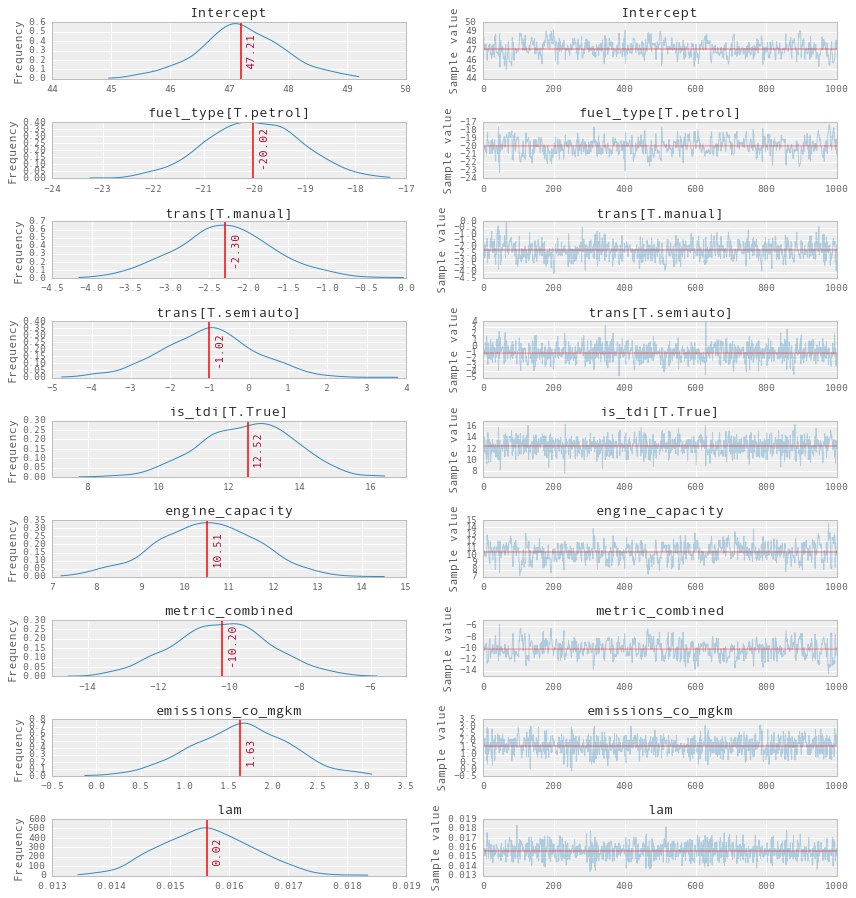

In [15]:
dfwaic_pymc['pooled'] = [pm.stats.waic(model=mdl_pooled_pymc, trace=trc_pooled_pymc[-1000:])]

rvs_pooled = [rv.name for rv in strip_derived_rvs(mdl_pooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_pooled_pymc[-1000:], varnames=rvs_pooled)

**Observe**:


+ Stuff



---

## PyStan Model

##### Spec model

In [16]:
mdl_pooled_stan_spec = """

    /* Spec for pooled regression linear model (robust) */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        vector[N] y;                        // endog feature
    }
    parameters {
        vector[K] beta;                     // exog coeffs
        real<lower=0> sigma;                // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);              // explicit prior for error (half-cauchy)
        y ~ student_t(1, X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
"""

In [17]:
mdl_pooled_stan_dict = {}
mdl_pooled_stan_dict['N'] = mx_ex.shape[0]
mdl_pooled_stan_dict['K'] = mx_ex.shape[1]
mdl_pooled_stan_dict['X'] = mx_ex.values
mdl_pooled_stan_dict['y'] = mx_en[ft_endog].values

##### Run model

In [18]:
if sample_switches['pooled']:

    mdl_pooled_stan_fit = pystan.stan(
            model_code  = mdl_pooled_stan_spec,
            data        = mdl_pooled_stan_dict,
            sample_file = ensure_dir('traces/trc_pooled_stan/chain'),
            model_name  = 'mdl_pooled_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_pooled_stan_fit.get_stanmodel(),
                 relnm='models/mdl_pooled_stan_model.pkl')

    write_pickle(mdl_pooled_stan_fit, 'models/mdl_pooled_stan_fit.pkl')
    
else:      
    ## load the model first, and then the fit:
    mdl_pooled_stan_model = read_pickle(relnm='models/mdl_pooled_stan_model.pkl')

    mdl_pooled_stan_fit = read_pickle(relnm='models/mdl_pooled_stan_fit.pkl')

Loaded object from disk at models/mdl_pooled_stan_model.pkl
Loaded object from disk at models/mdl_pooled_stan_fit.pkl


In [19]:
print(mdl_pooled_stan_fit)

Inference for Stan model: mdl_pooled_stan_e244f1e5de38aeb996031868b44b9554.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  47.22    0.05   0.68  45.84  46.76  47.21  47.69  48.57    209   1.01
beta[1] -20.09    0.06   0.95 -21.87 -20.73  -20.1 -19.45 -18.16    216   1.01
beta[2]  -2.25    0.04   0.57   -3.4  -2.63  -2.24  -1.88  -1.11    252   1.01
beta[3]  -0.89    0.07   1.18  -3.14  -1.71  -0.91  -0.09   1.47    257    1.0
beta[4]  12.33    0.09   1.38   9.62  11.38  12.35  13.28  14.94    241    1.0
beta[5]  10.44    0.08   1.14   8.25   9.64  10.44  11.21  12.58    198   1.01
beta[6] -10.08     0.1   1.39 -12.81 -10.98 -10.11  -9.09  -7.43    201   1.01
beta[7]   1.62    0.03   0.54   0.56   1.25   1.61   1.93   2.75    297    1.0
sigma     8.03    0.01   0.21   7.64   7.89   8.02   8.16   8.45    308    1.0
lp__     -7862    

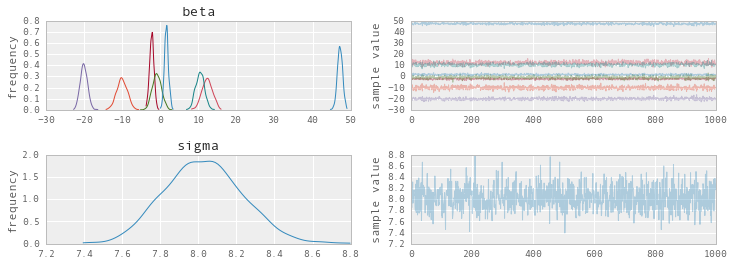

In [20]:
mdl_pooled_stan_fit.plot()
plt.show()

---

---

# Unpooled Model

Include the `mfr` feature values in the dmatrix. Each `mfr` value gets a separate intercept with shared slopes.


$$y \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \bf{x},\epsilon)$$

where:  
$\beta_{mfr}$ is a separate intercept for each manufacturer  
$\beta$ are our (shared) coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 


Set priors as Cauchy(0, 2.5) as per Gelman 2008? 
http://www.stat.columbia.edu/~gelman/research/published/priors11.pdf

Nope, in later correspondance, he recommends Normals http://andrewgelman.com/2015/11/01/cauchy-priors-for-logistic-regression-coefficients/

Lots of other thoughts at: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations


---

## PyMC3 Model

In [21]:
if sample_switches['unpooled']:

    with pm.Model() as mdl_unpooled_pymc:

        b0 = pm.Normal('b0_mfr', mu=0, sd=10, shape=n_mfr)

        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10)

        # define linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1 * mx_ex['fuel_type[T.petrol]'] + 
                 b2a * mx_ex['trans[T.manual]'] +
                 b2b * mx_ex['trans[T.semiauto]'] +
                 b3 * mx_ex['is_tdi[T.True]'] +
                 b4 * mx_ex['engine_capacity'] +
                 b5 * mx_ex['metric_combined'] +
                 b6 * mx_ex['emissions_co_mgkm'])

        ## Student T likelihood with HalfCauchy error and fixed DoF nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])
 
        ## sample
        trc_unpooled_pymc = pm.sample(2000, njobs=2, step=pm.NUTS()
                            ,start=pm.find_MAP(fmin=optimize.fmin_powell)     
                            ,trace=pm.backends.Text('traces/trc_unpooled_pymc'))
    ## dump to disk
    write_pickle(obj=mdl_unpooled_pymc, relnm='models/mdl_unpooled_pymc.pkl')
    
else:  
    with pm.Model():   ## read from disk

        mdl_unpooled_pymc = read_pickle(relnm='models/mdl_unpooled_pymc.pkl')

    trc_unpooled_pymc = pm.backends.text.load('traces/trc_unpooled_pymc',
                                              model=mdl_unpooled_pymc)


Loaded object from disk at models/mdl_unpooled_pymc.pkl


##### Save WAIC and view traces

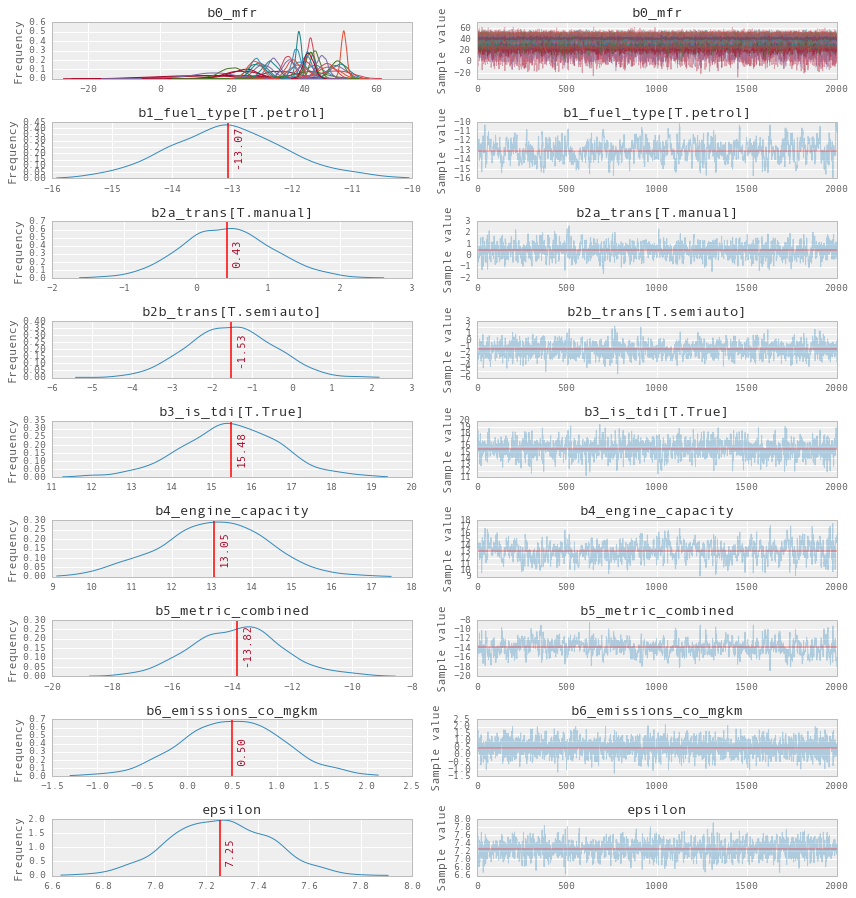

In [22]:
dfwaic_pymc['unpooled'] = [pm.stats.waic(model=mdl_unpooled_pymc,
                                         trace=trc_unpooled_pymc[-1000:])]

rvs_unpooled_pymc = [rv.name for rv in strip_derived_rvs(mdl_unpooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_unpooled_pymc[-1000:], varnames=rvs_unpooled_pymc)

---

## PyStan Model

##### Create model spec

In [23]:
mdl_unpooled_stan_spec = """

    /* Spec for unpooled regression linear model */

    data {                                 
        int<lower=0> N;                           // count of observations
        int<lower=0> K;                           // count of exog features
        matrix[N, K] X;                           // exog features
        vector[N] y;                              // endog feature
        int<lower=0> n_mfr;                   // count of mfr index levels
        int<lower=1,upper=n_mfr> mfr_enc[N];  // mfr index encoding  
    }
    parameters {
        vector[n_mfr] b0_mfr;                 // mfr intercept coeff
        vector[K] beta;                           // exog coeffs
        real<lower=0> sigma;                      // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);                    // prior for error
        y ~ student_t(1, b0_mfr[mfr_enc] + X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
"""

In [24]:
mdl_unpooled_stan_dict = {}
mdl_unpooled_stan_dict['N'] = mx_ex.iloc[:,1:].shape[0]
mdl_unpooled_stan_dict['K'] = mx_ex.iloc[:,1:].shape[1]
mdl_unpooled_stan_dict['X'] = mx_ex.iloc[:,1:].values
mdl_unpooled_stan_dict['y'] = mx_en[ft_endog].values

mdl_unpooled_stan_dict['mfr_enc'] = dfs['mfr_enc'].values + 1
mdl_unpooled_stan_dict['n_mfr'] = n_mfr

In [25]:
if sample_switches['unpooled']:

    mdl_unpooled_stan_fit = pystan.stan(
            model_code  = mdl_unpooled_stan_spec,
            data        = mdl_unpooled_stan_dict,
            sample_file = ensure_dir('traces/trc_unpooled_stan/chain'),
            model_name  = 'mdl_unpooled_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_unpooled_stan_fit.get_stanmodel(),
                 relnm='models/mdl_unpooled_stan_model.pkl')

    write_pickle(mdl_unpooled_stan_fit, 'models/mdl_unpooled_stan_fit.pkl')
    
else:      
    ## load the model first, and then the fit:
    mdl_unpooled_stan_model = read_pickle(relnm='models/mdl_unpooled_stan_model.pkl')

    mdl_unpooled_stan_fit = read_pickle(relnm='models/mdl_unpooled_stan_fit.pkl')

Loaded object from disk at models/mdl_unpooled_stan_model.pkl
Loaded object from disk at models/mdl_unpooled_stan_fit.pkl


##### View fit

In [26]:
print(mdl_unpooled_stan_fit)

Inference for Stan model: mdl_unpooled_stan_1a611946de1c04755ce7d5aaf1467813.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0_mfr[0]   54.73    0.17   3.04  48.99  52.63   54.6  56.65  61.39    311    1.0
b0_mfr[1]   60.75    0.14   2.48  55.79  59.08  60.82  62.44  65.45    304    1.0
b0_mfr[2]   51.55    0.35   6.35  39.71  47.21  51.51   55.8  64.06    334    1.0
b0_mfr[3]    53.4     0.1   1.39   50.7  52.46  53.43   54.3   56.3    185   1.01
b0_mfr[4]   54.43    0.12   1.84  50.75  53.11  54.51  55.74  58.02    248    1.0
b0_mfr[5]   44.55    0.05    0.7  43.22  44.09  44.54   45.0  46.01    221    1.0
b0_mfr[6]   57.33    0.24   3.63  47.92  55.48  57.83  59.84  63.33    235    1.0
b0_mfr[7]   44.16    0.09   1.31  41.71  43.22  44.21  45.03  46.79    216   1.01
b0_mfr[8]   38.75    0.12   2.08  34.57   37.4  38.67   40.1  42.82 

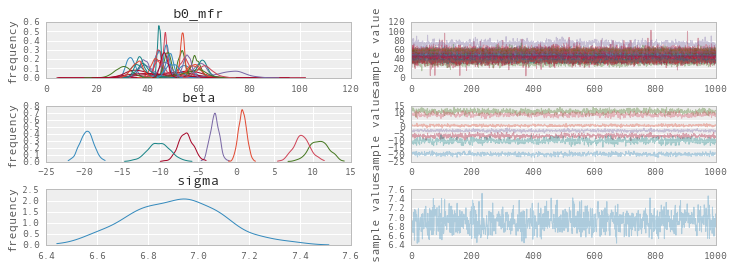

In [27]:
mdl_unpooled_stan_fit.plot()
plt.show()

---

## Evaluate Manufacturers using Unpooled Model

##### View forestplot of the `mfr` feature coeffs

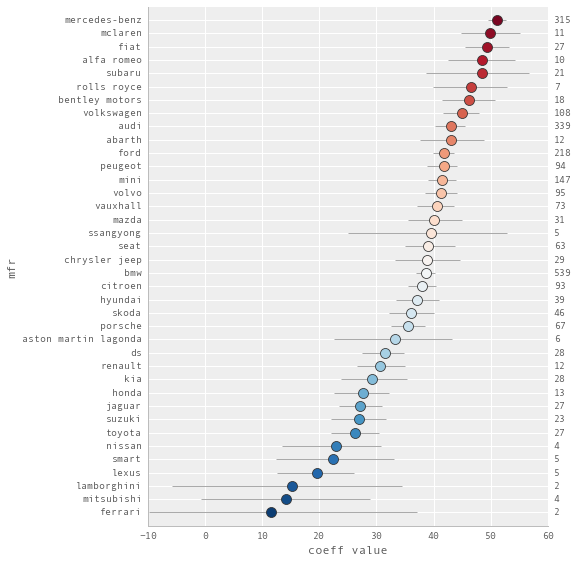

In [28]:
dfsm_unpl_mfr = create_smry(trc_unpooled_pymc[-1000:], dfs, 'mfr')
sg_mfrfreq = dfs.groupby('mfr').size().reindex(dfsm_unpl_mfr.index)

custom_forestplot(dfsm_unpl_mfr, sg_mfrfreq)

**Observe:**

The forestplot lets us compare the effect of `mfr` upon `emissions_nox_mgkm` when all other features in the mode are kept equal: `engine_capacity`, `fuel_type` etc etc

The forest plot shows:

+ The mean value for each parameter value, sorted in descending order
+ The uncertainty in each value, a.k.a. the Credible Region (CR) the region which the sample values spend X% of their time durng the traces. By convention I have chosen the 95% CR, but we could chose the 50% region or indeed anything that is useful for understanding.

Looking at the manufacturer values:

+ Mitsubuishi, seems to hang outside the pack by quite a long way
+ Jaguar and Lexus appear to emit least, however, you can see a weakness in this unpooled model, which is the massive uncertainty region for under-represented manufacturers

Under-representation is a problem:

+ Lamborghini and Lexus are represented in the dataset by 1 and 5 cars respectively and have massive CRs, so wide that we really can't say much about their effect upon emissions with certainty
+ Other manufacturers with few cars also have wide CRs: Mistubuishi (4), Ssangyong (5), Ferrari (2), Aston Martin Lagonda (6), and Smart (5)

We'll see later how this can be improved using partially-pooled model with a shared hyperparameter to 'share power' between the manufacturer parameters.

---

---

# Digression: Fully Unpooled Model

Of course, we can take this unpooling to an extreme, calculating separate intercepts and slopes for each manufacturer:

$$y \sim \mathcal{N}(\beta_{mfr}^{T} \bf{x},\epsilon)$$

where:  
$\beta_{mfr}$ are separate coeffs for each manufucturer
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 




---

## PyMC3 Model

In [29]:
if sample_switches['fullyunpooled']:

    with pm.Model() as mdl_fullyunpooled_pymc:

        b0 = pm.Normal('b0_mfr', mu=0, sd=10, shape=n_mfr)
        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10, shape=n_mfr)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10, shape=n_mfr)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10, shape=n_mfr)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10, shape=n_mfr)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10, shape=n_mfr)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10, shape=n_mfr)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10, shape=n_mfr)

        # define linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1[dfs['mfr_enc']] * mx_ex['fuel_type[T.petrol]'] + 
                 b2a[dfs['mfr_enc']] * mx_ex['trans[T.manual]'] +
                 b2b[dfs['mfr_enc']] * mx_ex['trans[T.semiauto]'] +
                 b3[dfs['mfr_enc']] * mx_ex['is_tdi[T.True]'] +
                 b4[dfs['mfr_enc']] * mx_ex['engine_capacity'] +
                 b5[dfs['mfr_enc']] * mx_ex['metric_combined'] +
                 b6[dfs['mfr_enc']] * mx_ex['emissions_co_mgkm'])

        ## Student T likelihood with fixed degrees of freedom nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])

        ## sample
        trc_fullyunpooled_pymc = pm.sample(10000, njobs=3, step=pm.Metropolis()
                                ,start=pm.find_MAP(fmin=optimize.fmin_powell)    
                                ,trace=pm.backends.Text('traces/trc_fullyunpooled_pymc'))

    ## dump to disk
    write_pickle(obj=mdl_fullyunpooled_pymc, relnm='models/mdl_fullyunpooled_pymc.pkl')
    
else:
    with pm.Model():    ## read from disk

        mdl_fullyunpooled_pymc = read_pickle(relnm='models/mdl_fullyunpooled_pymc.pkl')

    trc_fullyunpooled_pymc = pm.backends.text.load('traces/trc_fullyunpooled_pymc',
                                                   model=mdl_fullyunpooled_pymc)


Loaded object from disk at models/mdl_fullyunpooled_pymc.pkl


##### View traces

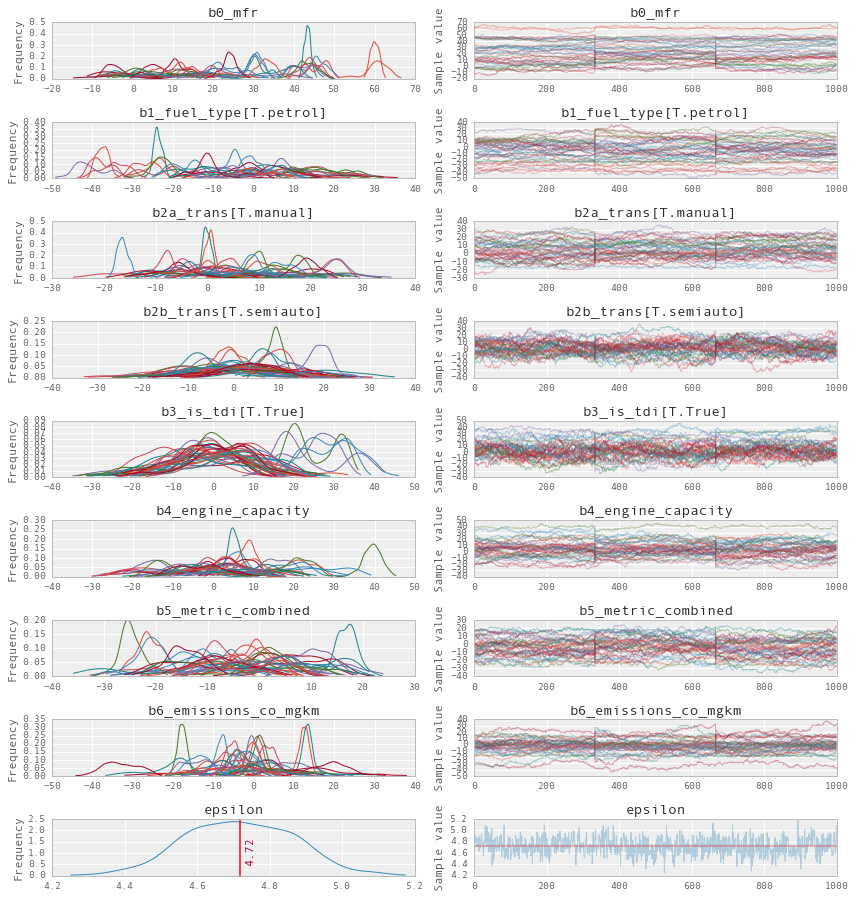

In [30]:
dfwaic_pymc['fullyunpooled'] = [pm.stats.waic(model=mdl_fullyunpooled_pymc,
                                         trace=trc_fullyunpooled_pymc[-333:])]
rvs_fullyunpooled_pymc = [rv.name for rv in \
                          strip_derived_rvs(mdl_fullyunpooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_fullyunpooled_pymc[-333:], varnames=rvs_fullyunpooled_pymc)

**Observe:**

There's three big issues with this fully unpooled model:

1. You'll notice I used the Metropolis sampler, rather than NUTS, because the NUTS sampler seemed to 'stall' and fail to move quickly around the posterior distribution - it sampled so slowly that it's unsuitable for this short demo.
2. Relatedly, the traces often show extreme values for parameters: likely because the separate values per manufacturer are simply allowed to vary too much and cause discontinuities in the posterior distribution.
3. Now, the differences between the manufacturers are captured across _all_ parameters in the mode, which makes comparing them really difficult! The mode may fit better (see the WAIC evaluation below), but we've made the task of human interpretation more difficult.

We have effectively fitted 38 seprate regressions, leading to immense complexity, slow sampling and messy traces. For this model at least, we need some degree of pooling.


**NOTE**: Regarding point 2 above: the slowness of NUTS sampling may possibly be something to do with the implementation in PyMC3, and I will look into this in future comparisons with Stan (via PyStan).

---

---

# Partially-Pooled Model

Here we place partial-pooling on intercept only: this hyperparameter lets us - in a balanced way - determine a difference between manufacturers `mfr` $m \in manufacturer$, keeping all other features constant

$$y \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \bf{x}, \epsilon)$$

where (tree written upside down):  
$\beta_{mfr} \sim \mathcal{N}(\mu_{mfr}, \sigma_{mfr})$

$\;\;\;\;\;\;\;\;\;\;\;\;|\_\_ \mu_{mfr} \sim \mathcal{N}(0, 100) \;\;;\;\;
\sigma_{mfr} \sim \mathcal{HalfCauchy}(0, 10)$ 

$\beta$ are the other (shared) coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 

---

## PyMC3 Model

In [31]:
if sample_switches['partpooled']:

    with pm.Model() as mdl_partpooled_pymc:

        # define hyperpriors for intercept
        b0_mu = pm.Normal('b0_mu', mu=0, sd=10)
        b0_sd = pm.HalfCauchy('b0_sd', beta=10)

        # define priors
        b0 = pm.Normal('b0_mfr', mu=b0_mu, sd=b0_sd, shape=n_mfr)
        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10)

        # define linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1 * mx_ex['fuel_type[T.petrol]'] + 
                 b2a * mx_ex['trans[T.manual]'] +
                 b2b * mx_ex['trans[T.semiauto]'] +
                 b3 * mx_ex['is_tdi[T.True]'] +
                 b4 * mx_ex['engine_capacity'] +
                 b5 * mx_ex['metric_combined'] +
                 b6 * mx_ex['emissions_co_mgkm'])

        ## Student T likelihood with fixed degrees of freedom nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])

        ## sample
        trc_partpooled_pymc = pm.sample(1000, njobs=2, step=pm.NUTS(),
                                start=pm.find_MAP(fmin=optimize.fmin_powell),
                                trace=pm.backends.Text('traces/trc_partpooled_pymc'))
    ## dump to disk
    write_pickle(obj=mdl_partpooled_pymc, relnm='models/mdl_partpooled_pymc.pkl')
    
else:
    with pm.Model():   ## read from disk

        mdl_partpooled_pymc = read_pickle(relnm='models/mdl_partpooled_pymc.pkl')

    trc_partpooled_pymc = pm.backends.text.load('traces/trc_partpooled_pymc',
                                                   model=mdl_partpooled_pymc)
    

Loaded object from disk at models/mdl_partpooled_pymc.pkl


##### Save WAIC and View traces

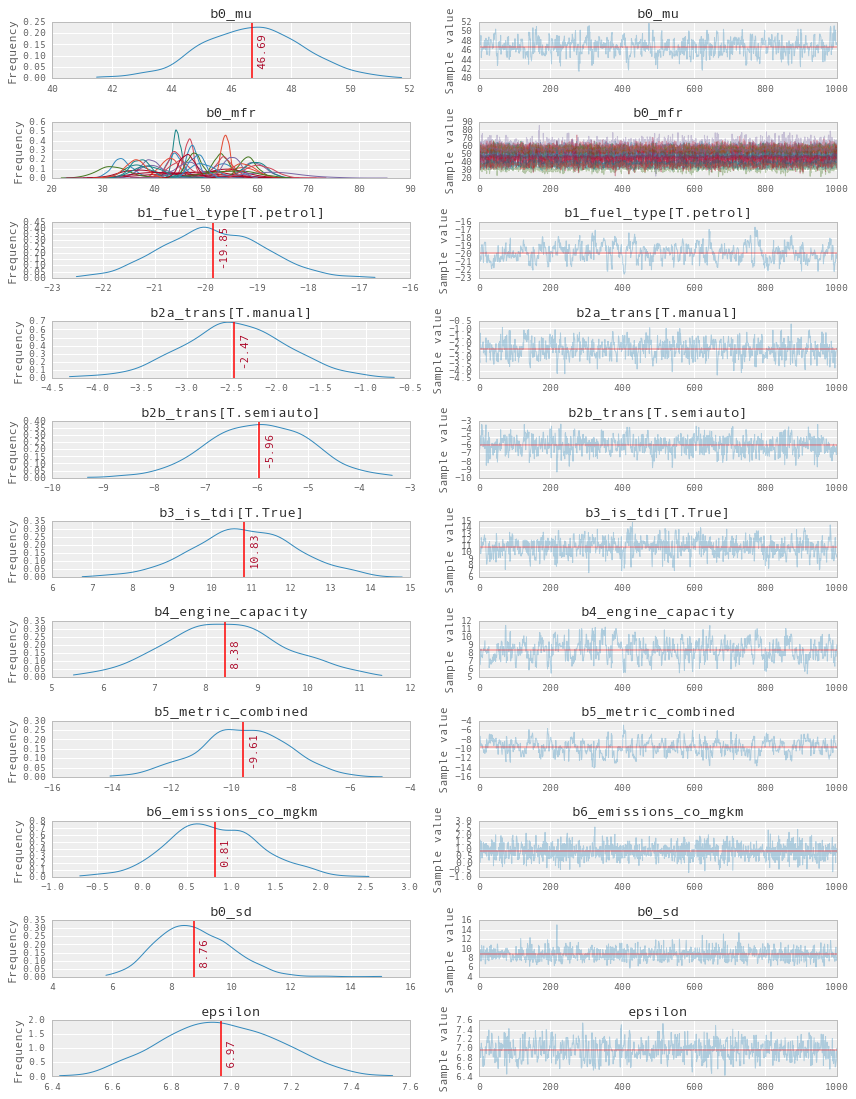

In [32]:
dfwaic_pymc['partpooled'] = [pm.stats.waic(model=mdl_partpooled_pymc,
                                         trace=trc_partpooled_pymc[-500:])]
rvs_partpooled_pymc = [rv.name for rv in \
                          strip_derived_rvs(mdl_partpooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_partpooled_pymc[-500:], varnames=rvs_partpooled_pymc)

**Observe:**

This is more like it:

+ The traceplots look pretty well-mixed
+ We have a shared mean for the intercept `b0_mu` at approx. 48.
+ All the 38 `mfr` values are located around this value, with standard deviation `b0_sd`: as we see in the plot for `b0_mfr`

---

## PyStan Model

In [33]:
mdl_partpooled_stan_spec = """

    /* Spec for partpooled regression linear model */

    data {                                 
        int<lower=0> N;                         // count of observations
        int<lower=0> K;                         // count of exog features
        matrix[N, K] X;                         // exog features
        vector[N] y;                            // endog feature
        int<lower=0> n_mfr;                     // count of mfr index levels
        int<lower=1, upper=n_mfr> mfr_enc[N];   // mfr index encoding  
    }
    parameters {
        vector[K] beta;                         // exog coeffs
        real<lower=0> sigma;                    // linear model error       

        real mfr_mu;                            // part-pooling prior mu
        real<lower=0> mfr_sd;                   // part-pooling prior sd    
        vector[n_mfr] b0_mfr;                   // mfr intercept coeff
    }
    transformed parameters {}
    model {  
        
        mfr_mu ~ normal(0, 10);                  // part-pooling prior mu
        mfr_sd ~ cauchy(0, 10);                  // part-pooling prior sd
     
        for (mfr in 1:n_mfr) {
              b0_mfr[mfr] ~ normal(mfr_mu, mfr_sd);
        }
    
        sigma ~ cauchy(0, 10);                    // prior for error
        y ~ student_t(1, b0_mfr[mfr_enc] + X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
"""

In [34]:
if sample_switches['partpooled']:

    mdl_partpooled_stan_fit = pystan.stan(
            model_code  = mdl_partpooled_stan_spec,
            data        = mdl_unpooled_stan_dict,
            sample_file = ensure_dir('traces/trc_partpooled_stan/chain'),
            model_name  = 'mdl_partpooled_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_partpooled_stan_fit.get_stanmodel(),
                 relnm='models/mdl_partpooled_stan_model.pkl')

    write_pickle(mdl_partpooled_stan_fit, 'models/mdl_partpooled_stan_fit.pkl')
    
else:      
    ## load the model first, and then the fit:
    mdl_partpooled_stan_model = read_pickle(relnm='models/mdl_partpooled_stan_model.pkl')

    mdl_partpooled_stan_fit = read_pickle(relnm='models/mdl_partpooled_stan_fit.pkl')

Loaded object from disk at models/mdl_partpooled_stan_model.pkl
Loaded object from disk at models/mdl_partpooled_stan_fit.pkl


##### View summary

In [35]:
print(mdl_partpooled_stan_fit)

Inference for Stan model: mdl_partpooled_stan_84085e84ce57e47d7eaa8c803400591d.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    -19.84    0.07   0.98 -21.88 -20.48 -19.81  -19.2 -18.08    197    1.0
beta[1]     -2.49    0.04   0.64  -3.74  -2.91  -2.49  -2.08  -1.28    286    1.0
beta[2]     -6.02    0.07   1.05  -8.06   -6.7  -6.06  -5.33  -3.91    233    1.0
beta[3]     11.09    0.08   1.25   8.72  10.21  11.08  11.96  13.53    267    1.0
beta[4]      8.46    0.07   1.14   6.19   7.76   8.47   9.22   10.6    238    1.0
beta[5]     -9.69     0.1   1.51 -12.57 -10.68  -9.77  -8.77  -6.56    227    1.0
beta[6]      0.82    0.03   0.51  -0.17   0.48   0.82   1.14    1.9    333    1.0
sigma        6.95    0.01   0.19   6.59   6.82   6.95   7.08   7.32    334    1.0
mfr_mu      46.77    0.09   1.59  43.57  45.68  46.79  47.89  49.8

##### View traces

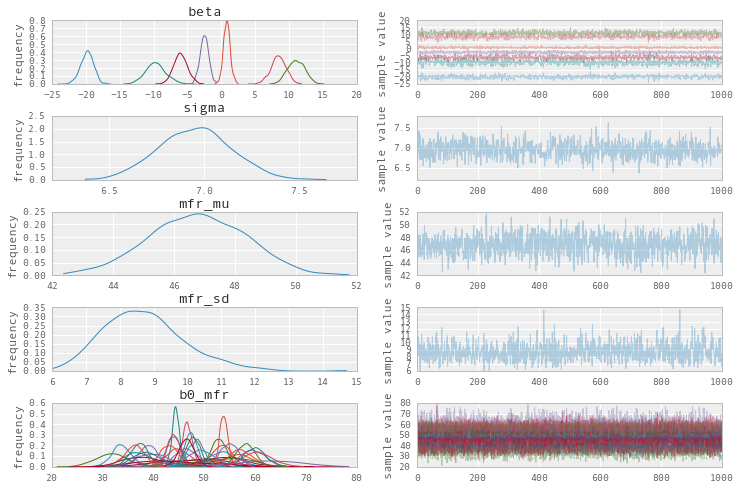

In [36]:
f = mdl_partpooled_stan_fit.plot()
f.set_size_inches(12, 8)
plt.show()

### Compare PyStan model coeffs to PyMC3 coeffs

In [37]:
# return a dictionary of arrays
samples = mdl_partpooled_stan_fit.extract(permuted=True)
for k, v in samples.items():
    print(k, v.shape)

beta (1000, 7)
sigma (1000,)
mfr_mu (1000,)
mfr_sd (1000,)
b0_mfr (1000, 38)
lp__ (1000,)


In [38]:
pd.DataFrame(samples['beta'], columns=mx_ex.columns[1:]).describe().T

,count,mean,std,min,25%,50%,75%,max
fuel_type[T.petrol],1000.0,-19.840191,0.976404,-24.118923,-20.484078,-19.806252,-19.202676,-16.349455
trans[T.manual],1000.0,-2.493453,0.635573,-4.890906,-2.906765,-2.491855,-2.078795,-0.698668
trans[T.semiauto],1000.0,-6.018969,1.045010,-9.720177,-6.697906,-6.056220,-5.330050,-2.640095
is_tdi[T.True],1000.0,11.090015,1.249376,7.190735,10.206637,11.078221,11.958024,15.181916
engine_capacity,1000.0,8.458315,1.136637,3.988364,7.763162,8.473689,9.215543,11.839760
metric_combined,1000.0,-9.692917,1.512539,-14.411599,-10.676592,-9.767161,-8.773176,-3.815124
emissions_co_mgkm,1000.0,0.821418,0.508222,-0.944322,0.480995,0.817767,1.144348,2.509642


##### Compare to PyMC3

In [39]:
pm.df_summary(trc_partpooled_pymc[-500:], varnames=rvs_partpooled_pymc).iloc[-9:-2,:]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b1_fuel_type[T.petrol],-19.851495,0.981491,0.069182,-21.598572,-17.854109
b2a_trans[T.manual],-2.468407,0.585412,0.026239,-3.650154,-1.332281
b2b_trans[T.semiauto],-5.957028,0.978052,0.041755,-7.832069,-4.028871
b3_is_tdi[T.True],10.831287,1.300037,0.063394,8.428123,13.572542
b4_engine_capacity,8.381849,1.142679,0.073880,6.152609,10.623605
b5_metric_combined,-9.612457,1.483942,0.100170,-12.458841,-6.770456
b6_emissions_co_mgkm,0.814999,0.513168,0.014822,-0.080702,1.898147


> Looks similar!

---

## Evaluate Manufacturers using Partially-Pooled PyMC3 Model

Let's compare the forestplot for this partpooled model with that of the unpooled model

In [40]:
dfsm_ptpl_mfr = create_smry(trc_partpooled_pymc[-500:], dfs, 'mfr')

In [41]:
dfsm_mfr_vs = pd.concat((dfsm_ptpl_mfr
                         ,dfsm_unpl_mfr.reindex(dfsm_ptpl_mfr.index)), axis=0)
dfsm_mfr_vs['mdl'] = np.concatenate(
                    (np.repeat(['partpooled'],38), np.repeat('unpooled',38)))
dfsm_mfr_vs.iloc[38:]['ypos'] = dfsm_mfr_vs.iloc[:38]['ypos']

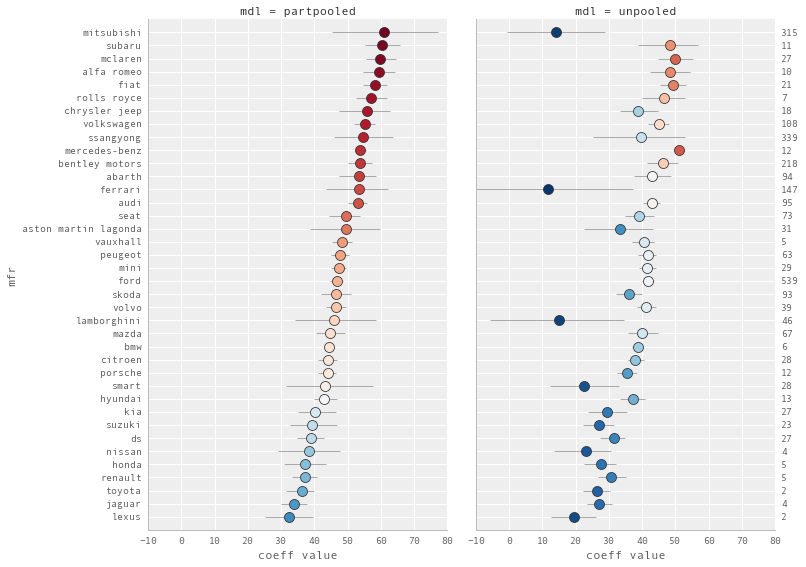

In [42]:
custom_forestplot(dfsm_mfr_vs, sg_mfrfreq, aspect=0.6, facetby='mdl')

**Observe:**

+ The forestplot for the `partpooled` model is shown on the left and the `unpooled` is on the right. Note the rows are ordered according to the `partpooled` model.
+ There's a few small changes in ordering from the `unpooled` model, for instance: Ssangyong, Mercedes-Benz, Ferrari
+ There's a noticable reduction in uncertainty for some parameters which have low counts, for instance: Lamborghini (1 car), Lexus (5 cars) and Smart (5 cars)

**Shrinkage**

Overall all the parameters appear to be pulled in slightly closer together, this is a.k.a 'shrinkage'
+ The coeffs now occupy a region between 34 - 62, centered on approx 50. This compares to the unpooled model where parameters have a region between 32 and 72. 
+ This reduction in variance would suggest the `partpooled` model is less overfitted than the `unpooled`, and may perform better in hold-out validation.



---

## Can we comment on Volkswagen's NOx emissions at `mfr` level?

We can see from the above that the intercept parameter for `mfr == volkswagen` is 8th highest in the pack of all 38 manufacturers, seemingly higher than average.

Let's take a more detailled look at the parameter value compared to the group mean

In [43]:
## Summary of Volkswagen

dfsm_ptpl_mfr.loc[['volkswagen']]

,featval,mean,sd,mc_error,hpd_2.5,hpd_97.5,ypos
volkswagen,b0_mfr__36,55.120363,1.665361,0.087742,51.883923,58.30473,30


In [44]:
## Hyperprior group mean and standard dev

pm.df_summary(trc_partpooled_pymc[-500:], varnames=['b0_mu','b0_sd'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_mu,46.692108,1.694310,0.086228,43.057797,49.741975
b0_sd,8.764461,1.212659,0.041439,6.733600,11.224035


**Observe:**

The model is specified such that all 38 `mfr` parameters share a common hyperparameter `b0_mu` for their mean, and common hyperparameter `b0_sd` for their standard deviation.

+ Looking at the **mean**:  
Volkswagen has a mean value of `55.32` with a 95% CR from `52.12 to 58.15`  
The group mean `b0_mn` has a mean value much lower at `48.15` with a 95% CR from `44.76 to 51.80`  
The 95% CR for Volkswagen does not overlap with the 95% CR for the group mean, so we can say that it is strongly above the mean for NOx emissions.


+ Looking at the **standard deviation**:  
Volkswagen has a sd value of `1.60`   
The group sd `b0_sd` has a mean value much higher at `8.71` with a 95% CR from `6.34 to 10.99`  
The sd for Volkswagen does not overlap with the 95% CR for the group sd, so we can say that Volkswagen has a strongly narrow distribution in its mean NOx emissions.


+ **In summary**  it seems that Volkswagen has an unusually high and tight parameter explaining their NOx emissions.



**Caveat: This is far from rigorous!**  

1. The manufacturer parameter values are all quite well distributed through a large range `34 to 62` and don't always overlap with one another. We can make the same inference of 'tightly above average NOx emissions' for several other manufacturers: Rolls Royce, Fiat, Alfa Romeo, Maclaren and Subaru.
2. We haven't considered the manufacturer-owner parameter `mfr_owner`: which is higher-level information and may help with the class imbalances on `mfr`

---

---

# Hierarchical Model of Parent and Manufacturer

Since I wanted to build the case slowly, I've not yet considered `parent`: the manufacturer parent company.

Now's the time to consider it: because the parent company may provide important information. 

We could create another part-pooled model like above, with `parent` as a separate set of parameter coeffs, but quite obviously the `mfr` correolates completely with `parent` in a hierarchical structure; we can't assume orthogonality in the model.

Rather than have all `mfr`s joined by a single hyperparameter, let's instead join them to a hyperparameter set by their parent company `parent`. These 20 `parent` levels will in turn be joined to a single hyperparameter. It's just an extension of the part-pooling model to create a truely hierarchical model which incorporates the ownership structure we know about. 


$$y \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \bf{x}, \epsilon)$$

where (tree written upside down):  
$\beta_{mfr} \sim \mathcal{N}(\mu_{mfr}, \sigma_{mfr})$

$\;\;\;\;|\_\_ \mu_{mfr} \sim \mathcal{N}(\mu_{parent}, \sigma_{parent}) \;\;;\;\;
\sigma_{mfr} \sim \mathcal{HalfCauchy}(0, 10)$ 

$\;\;\;\;\;\;\;\;\;\;|\_\_  \mu_{parent} \sim \mathcal{N}(0, 10) \;\; ; \;\; \sigma_{parent}\sim \mathcal{HalfCauchy}(0, 10)$  


$\beta$ are the other (shared) coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 

---

## PyMC3 Model

In [45]:
# if sample_switches['hier']:

#     with pm.Model() as mdl_hier_pymc:

#         # set theano constants for convenient theano object indexing
#         parent_enc = T.constant(dfs['parent_enc'])

#         # define hyperpriors for intercept based on parent   # 1x of these
#         b0_parent_mn = pm.Normal('b0_parent_mn', mu=0, sd=10)
#         b0_parent_sd = pm.HalfCauchy('b0_parent_sd', beta=10)

#         # define hyperpriors for mfr based on parent         # 20x of these
#         b0_parent = pm.Normal('b0_parent', mu=b0_parent_mn, sd=b0_parent_sd, shape=n_parent)
#         b0_mfr_sd = pm.HalfCauchy('b0_mfr_sd', beta=10)

#         # define priors
#         # use T.sum to nondestructively cast indexed val to a theano object 
#         b0 = pm.Normal('b0_mfr', mu=T.sum(b0_parent[parent_enc]),
#                        sd=b0_mfr_sd ,shape=n_mfr)    # 38x of these

#         b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10)
#         b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10)
#         b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10)
#         b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10)
#         b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10)
#         b5 = pm.Normal('b5_metric_combined', mu=0, sd=10)
#         b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10)

#         # define hierachical linear model
#         yest = ( b0[dfs['mfr_enc']] +
#                  b1 * mx_ex['fuel_type[T.petrol]'] + 
#                  b2a * mx_ex['trans[T.manual]'] +
#                  b2b * mx_ex['trans[T.semiauto]'] +
#                  b3 * mx_ex['is_tdi[T.True]'] +
#                  b4 * mx_ex['engine_capacity'] +
#                  b5 * mx_ex['metric_combined'] +
#                  b6 * mx_ex['emissions_co_mgkm'])

#         ## Student T likelihood with fixed degrees of freedom nu
#         epsilon = pm.HalfCauchy('epsilon', beta=10)
#         likelihood = pm.StudentT('likelihood', nu=1, mu=yest
#                                  ,sd=epsilon, observed=dfs[ft_endog])

#         ## sample
#         # NOTE: NUTS gets stuck or runs incredibly slowly: ~100 sec /sample /chain
#         trc_hier_pymc = pm.sample(1000, njobs=3, step=pm.Metropolis()
#                                #,start=pm.find_MAP(fmin=optimize.fmin_powell)
#                                ,trace=pm.backends.Text('traces/trc_hier_pymc'))

#     ## dump to disk
#     write_pickle(obj=mdl_hier_pymc, relnm='models/mdl_hier_pymc.pkl')

        
# else:
#     with pm.Model():   ## read from disk

#         mdl_hier_pymc = read_pickle(relnm='models/mdl_hier_pymc.pkl')

#     trc_hier_pymc = pm.backends.text.load('traces/trc_hier_pymc',
#                                           model=mdl_hier_pymc)
    


##### Save WAIC and view traceplots

In [46]:
# # dfwaic_pymc['hier'] = [pm.stats.waic(model=mdl_hier_pymc,
# #                                          trace=trc_hier_pymc[-500:])]
# rvs_hier_pymc = [rv.name for rv in strip_derived_rvs(mdl_hier_pymc.unobserved_RVs)]
# plot_traces_pymc(trc_hier_pymc[-500:], varnames=rvs_hier_pymc)

---

## PyStan Model

In [64]:
mdl_hier_stan_spec = """

    /* Spec for hierarchical regression linear model */

    data {                                 
        int<lower=0> N;                         // count of observations
        int<lower=0> K;                         // count of exog features
        matrix[N, K] X;                         // exog features
        vector[N] y;                            // endog feature

        int<lower=0> n_parent;                      // count of parent index levels
        int<lower=1, upper=n_parent> parent_enc[N]; // parent index encoding  
        
        int<lower=0> n_mfr;                     // count of mfr index levels
        int<lower=1, upper=n_mfr> mfr_enc[N];   // mfr index encoding          
    }
    parameters {
        vector[K] beta;                         // exog coeffs
        real<lower=0> sigma;                    // linear model error       

        real parent_mu;                         // parent mu hyperprior
        real<lower=0> parent_sd;                // parent sd hyperprior

        //vector [n_parent] b0_parent;             // parent (mfr mu hyperprior)
        real b0_parent[n_parent];
        real<lower=0> mfr_sd;                   // mfr mu hyperprior

        //vector[n_mfr] b0_mfr;                     // mfr 
        real b0_mfr[n_mfr];
    }
    transformed parameters {}
    model {  
               
        for (n in 1:N){

            parent_mu ~ normal(0, 10);
            parent_sd ~ cauchy(0, 10);
            b0_parent[parent_enc[n]] ~ normal(parent_mu, parent_sd); 
            
            mfr_sd ~ cauchy(0, 10);    
            b0_mfr[mfr_enc[n]] ~ normal(b0_parent[parent_enc[n]], mfr_sd);

            sigma ~ cauchy(0, 10);
            y[n] ~ student_t(1, b0_mfr[mfr_enc[n]] + X[n] * beta, sigma); 
        }
    }
    generated quantities {}
"""

In [65]:
mdl_hier_stan_dict = {}
mdl_hier_stan_dict['N'] = mx_ex.iloc[:,1:].shape[0]
mdl_hier_stan_dict['K'] = mx_ex.iloc[:,1:].shape[1]
mdl_hier_stan_dict['X'] = mx_ex.iloc[:,1:].values
mdl_hier_stan_dict['y'] = mx_en[ft_endog].values

mdl_hier_stan_dict['parent_enc'] = dfs['parent_enc'].values + 1
mdl_hier_stan_dict['n_parent'] = n_parent
mdl_hier_stan_dict['mfr_enc'] = dfs['mfr_enc'].values + 1
mdl_hier_stan_dict['n_mfr'] = n_mfr

In [66]:
if sample_switches['hier']:

    mdl_hier_stan_fit = pystan.stan(
            model_code  = mdl_hier_stan_spec,
            data        = mdl_hier_stan_dict,
            sample_file = ensure_dir('traces/trc_hier_stan/chain'),
            model_name  = 'mdl_hier_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_hier_stan_fit.get_stanmodel(),
                 relnm='models/mdl_hier_stan_model.pkl')

    write_pickle(mdl_hier_stan_fit, 'models/mdl_hier_stan_fit.pkl')
    
else:      
    ## load the model first, and then the fit:
    mdl_hier_stan_model = read_pickle(relnm='models/mdl_hier_stan_model.pkl')

    mdl_hier_stan_fit = read_pickle(relnm='models/mdl_hier_stan_fit.pkl')

##### View summary

In [67]:
print(mdl_hier_stan_fit)

Inference for Stan model: mdl_hier_stan_cf2eeee1cad67f3d180d4ca0084c0a09.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]         0.81    0.72   1.02  -0.53  -0.21   0.91   1.81   1.95      2    nan
beta[1]         0.71     0.9   1.27  -0.84  -0.57   0.78   1.97   2.12      2    nan
beta[2]         0.24     0.7   0.99  -0.89  -0.72   0.15   1.22   1.54      2    nan
beta[3]        -0.64    0.57   0.81  -1.46  -1.36  -0.86   0.12   0.61      2    nan
beta[4]        -0.46    1.14   1.61  -2.08  -1.93  -0.86   1.09   1.97      2    nan
beta[5]        -0.05     0.8   1.14  -1.36  -1.08  -0.25   1.01   1.65      2    nan
beta[6]         0.11    0.63    0.9  -0.69  -0.59  -0.25   0.87    1.6      2    nan
sigma           8.17    0.09   0.13   8.04   8.05   8.15    8.3   8.33      2    nan
parent_mu       0.06    0.19   0.27  -0.36  -

##### Get items from the fit

In [68]:
# return a dictionary of arrays
samples = mdl_hier_stan_fit.extract(permuted=True)
for k, v in samples.items():
    print(k, v.shape)

beta (1000, 7)
sigma (1000,)
parent_mu (1000,)
parent_sd (1000,)
b0_parent (1000, 20)
mfr_sd (1000,)
b0_mfr (1000, 38)
lp__ (1000,)


In [51]:
# print(mdl_hier_stan_fit)

##### View traces

In [ ]:
f = mdl_hier_stan_fit.plot()
f.set_size_inches(12, 10)
plt.show()

---

---

---

# Digression: Model Comparison using WAIC

The Widely Applicable Bayesian Information Criterion, a.k.a the Watanabe - Akaike Information Criterion (WAIC) is a relatively simple option for calculating the goodness-of-fit of a model using numerical techniques. See [(Watanabe 2013)](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) for details.

WAIC is [suggested to be be better than DIC for evaluating hierarchical models](https://groups.google.com/forum/#!searchin/stan-users/map/stan-users/-QwWiDbQp3U/arfSXTzcAwAJ), so I use it here to compare the models. **A lower value indicates a 'better' model: trading off model fit vs complexity**.


During the above model runs, I've evaluated the WAIC using the built-in `pymc3.stats.waic` function for convenience. Both WAIC and DIC (Deviance Information Criterion) are recent additions to PyMC3, and I've submitted a [Notebook on model selection to the PyMC3 examples folder](http://pymc-devs.github.io/pymc3/GLM-model-selection/) comparing the two on a simple linear model. You may find it useful.


Lets take a look:

In [ ]:
dfm = pd.melt(dfwaic.reset_index(), id_vars='index')
g = sns.factorplot(x='value', y='variable', data=dfm, kind='bar', size=2, aspect=5)

for i, p in enumerate(g.ax.patches):
    val = p.get_width()
    _ = g.ax.annotate('{:,.2f}'.format(val), xy=(val,i), xycoords='data'
                ,xytext=(-10,0), textcoords='offset points'
                ,va='center', ha='right', fontsize=12, color='w')

**Observe:**

+ The `fullyunpooled` model appears to have the best WAIC, which makes some sense, since this has 38 degrees of freedom in each parameter and so can fit our dataset very well
+ This may be overfitted however, so in practice it would be vital to evaluate the models using cross-validation
+ The `pooled` model has the worst WAIC, which also makes sense, since it has the fewest degrees of freedom: basically ignoring the `mfr` parameter
+ The `partpooled` model appears to perform about as well as the `unpooled` model, which is nice to see, since the partial pooling could potentially 'smudge out' the differences between `mfr`s to the point that we get the `pooled` model again.

---

# Final look at mfr_owner with a Partially-Pooled Model

In [ ]:
with pm.Model() as mdl_partpooled_mfrowner:

    # define hyperpriors for intercept
    b0_mu = pm.Normal('b0_mu', mu=0, sd=100)
    b0_sd = pm.HalfCauchy('b0_sd', beta=10)
      
    # define priors, use Normal for Ridge (sd=100, weakly informative)
    b0 = pm.Normal('b0_mfr_owner', mu=b0_mu, sd=b0_sd, shape=n_mfr_owner_enc)
    b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=100)
    b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=100)
    b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=100)
    b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=100)
    b4 = pm.Normal('b4_engine_capacity', mu=0, sd=100)
    b5 = pm.Normal('b5_metric_combined', mu=0, sd=100)
    b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=100)
    
    # define linear model
    yest = ( b0[dfs['mfr_owner_enc']] +
             b1 * mx_ex_unpooled['fuel_type[T.petrol]'] + 
             b2a * mx_ex_unpooled['trans[T.manual]'] +
             b2b * mx_ex_unpooled['trans[T.semiauto]'] +
             b3 * mx_ex_unpooled['is_tdi[T.True]'] +
             b4 * mx_ex_unpooled['engine_capacity'] +
             b5 * mx_ex_unpooled['metric_combined'] +
             b6 * mx_ex_unpooled['emissions_co_mgkm'])
      
    ## Student T likelihood with fixed degrees of freedom nu
    epsilon = pm.HalfCauchy('epsilon', beta=10)
    likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                             ,sd=epsilon, observed=dfs[ft_endog])
    
    if sample_switches['partpooled_mfrowner']:
        trc_partpooled_mfrowner = pm.sample(1000, njobs=3, step=pm.NUTS()
                               ,start=pm.find_MAP(fmin=optimize.fmin_powell)
                               ,trace=pm.backends.Text('traces_txt/trc_partpooled_mfrowner'))
    else:
        trc_partpooled_mfrowner = pm.backends.text.load('traces_txt/trc_partpooled_mfrowner')
    

##### View traces

In [ ]:
dfwaic['partpooled_mfrowner'] = [pm.stats.waic(model=mdl_partpooled_mfrowner
                                               ,trace=trc_partpooled_mfrowner[-333:])]
rvs_partpooled_mfrowner = [rv.name for rv 
                           in strip_derived_rvs(mdl_partpooled_mfrowner.unobserved_RVs)]
plot_traces(trc_partpooled_mfrowner[-333:], varnames=rvs_partpooled_mfrowner)

## Evaluate Manufacturers using Partially-Pooled `mfr_owner` Model

Reminder of how the manufacturer ownership is structured: counts of cars (ows in the dataset) by manufacturer and parent group:

In [ ]:
f, ax1d = plt.subplots(1,1,figsize=(12,6))
ax = sns.heatmap(dfs.groupby(['mfr_owner','mfr']).size().unstack()
    ,annot=True, fmt='.0f', cbar=False, ax=ax1d, cmap='BuPu')

As we saw before, there's quite an imbalance between the manufacturers and even the owners. Three conglomerate groups are heavily represented in the dataset: `bmw`, `daimler-ag`, and `volkswagen`

Let's view the forestplot for the `mfr_owner` parameters

In [ ]:
dfsm_ptpl_mfr_owner = create_smry(trc_partpooled_mfrowner[-333:], dfs, 'mfr_owner')
custom_forestplot(dfsm_ptpl_mfr_owner, ylabel='mfr_owner', size=6)

**Observe:**

+ With only 20 `mfr_owner` parameters, this forestplot is simpler to view
+ 

## Can we comment on Volkswagen's NOx emissions at `mfr_owner` level?

We can see from the above that the intercept parameter for `mfr == volkswagen` is 5th highest in the pack of all 20 mfr_owners, seemingly higher than average.

Let's take a more detailled look at the parameter value compared to the group mean

In [ ]:
## Summary of Volkswagen

dfsm_ptpl_mfr_owner.loc[['volkswagen']]

In [ ]:
## Hyperprior group mean and standard dev

pm.df_summary(trc_partpooled_mfrowner[-333:], varnames=['b0_mu','b0_sd'])

**Observe:**

The model is specified such that all 20 `mfr_owner` parameters share a common hyperparameter `b0_mu` for their mean, and common hyperparameter `b0_sd` for their standard deviation.

+ Looking at the **mean**:  
Volkswagen has a mean value of `54.51` with a 95% CR from `52.98 to 56.03`  
The group mean `b0_mn` has a mean value much lower at `47.60` with a 95% CR from `43.23 to 51.55`  
The 95% CR for Volkswagen does not overlap with the 95% CR for the group mean, so we can say that it is strongly above the mean for NOx emissions.


+ Looking at the **standard deviation**:  
Volkswagen has a sd value of `0.78`   
The group sd `b0_sd` has a mean value much higher at `9.36` with a 95% CR from `6.14 to 12.74` 
The sd for Volkswagen does not overlap with the 95% CR for the group sd, so we can say that Volkswagen has a strongly narrow distribution in its mean NOx emissions.


+ **In summary**  it seems that Volkswagen Group has a high parameter explaining their NOx emissions. This paramter is also unusually tightly distributed, especially considering that it comprises 7 different `mfr` values.


**Caveat: This is _still_ far from rigorous!** It would be interesting to try a hierarchical model that includes both `mfr_owner` and `mfr`, but I'll leave that for another day.

---
**&copy; Applied AI Ltd 2016**  
<a href='http://www.applied.ai'>applied.ai</a>